In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import os
import time
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
import numpy as np

2023-02-15 15:37:00.643313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:37:01.448739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-15 15:37:01.448826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-15 15:37:01.448832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
class ReboilerBinaryClassifier:
    FEATURES_NUM = 8
    OUTPUT_NUM = 2

    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self):
        return pd.read_csv(self.filepath)
        
    def generate_data_processing_pipeline(self, X):
        num_attribs = X.select_dtypes(exclude=['object']).columns.tolist() # numerical attributes
        cat_attribs = X.select_dtypes(include=['object']).columns.tolist() # categorical attributes. In this case, it is only the 'Fecha' column.       
        
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), # fill missing values with column mean
            ('min_max_scaler', MinMaxScaler()) # scale the data between 0 and 1
        ])
        
        pipeline = ColumnTransformer([
            ('num', num_pipeline, num_attribs), # apply the numerical pipeline to the numerical attributes
            ('cat', CustomDataFormatter(cat_attribs), cat_attribs) # apply the custom class to convert text to datetime
        ])
        
        return pipeline 
                
    def split_and_process_data(self, data, val_size=0.2, test_size=0.2, save_pipeline=True):
        X = data.iloc[:, 1:-1] # all rows, all columns except first (datetime) and last (label)
        y = data.iloc[:, -1] # all rows, last column (label)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, random_state=42)        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=42)

        pipeline = self.generate_data_processing_pipeline(X_train) # considers only X_train to scale
        X_train = pipeline.fit_transform(X_train) # fit scaling and fillNA with X_train
        X_val = pipeline.transform(X_val) # apply pipeline to X_val (doesn't recalculate mean)
        X_test = pipeline.transform(X_test) # apply pipeline to X_test (doesn't recalculate mean)

        if save_pipeline: # to apply data transformation on new instances 
            joblib.dump(pipeline, 'pipeline.joblib')

        return X_train, y_train, X_val, y_val, X_test, y_test

    ########################## NEURAL NETWORK MODEL ##########################
    
    def create_model(self, print_summary=True):    

        model = keras.models.Sequential([
            keras.layers.Dense(32, input_shape=(ReboilerBinaryClassifier.FEATURES_NUM,), activation='sigmoid'),
            # keras.layers.Dense(ReboilerBinaryClassifier.OUTPUT_NUM-1, activation="sigmoid")
            keras.layers.Dense(ReboilerBinaryClassifier.OUTPUT_NUM, activation="softmax")
        ])

        model.compile(
            loss='sparse_categorical_crossentropy', # with softmax (e.g. 0, 1, 2, 3, 4...)
            # loss="binary_crossentropy", # with sigmoid (e.g. 0 or 1)
            optimizer="adam",
            metrics=["accuracy"]
        )
        if print_summary:
            model.summary()

        return model
    
    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=100, *, name=None):
        run_logdir = self.get_run_logdir(name)
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) # callback to create event files within run_logdir
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1) # interrupt training if validation shows no progress in 10 epochs
        history = model.fit(
            X_train, y_train, epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[tensorboard_cb, early_stopping_cb]
        )


    def evaluate_model(self, model, X_test, y_test, save_confusion_matrix=True):
        y_prob = model.predict(X_test) # probabilities
        y_pred = y_prob.argmax(axis=-1) # predictions
        # accuracy = model.evaluate(X_test, y_test)[1] # [loss, accuracy]
        accuracy = accuracy_score(y_test, y_pred)
        print('Accuracy on test set: {}'.format(accuracy))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues', colorbar=False)
        plt.title('Confusion Matrix')
        plt.grid(False)   
        if save_confusion_matrix:
            plt.savefig("confusion-matrix.png", dpi=300)
        plt.show()

    def plot_roc_curve(self, model, X_test, y_test, save_roc_curve=True, label='Neural Network'):
        y_scores = model.predict(X_test)[:, -1] # probabilities of positive cases "1"
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        print('AUC =', roc_auc_score(y_test, y_scores))
        plt.plot(fpr, tpr, label=label)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curve')
        plt.legend()
        if save_roc_curve:
            plt.savefig("roc_curve.png", dpi=300)
        plt.show()

    def save_model(self, model, name='model'):
        name += '.h5'
        model.save(name)

    def load_model(self, model):
        return keras.models.load_model(model)
    
    def predict(self, model_path, X_new, pipeline_path):
        pipeline = joblib.load(pipeline_path)
        # print('X_new type before transform:', type(X_new))
        X_new = pipeline.transform(X_new)
        # print('X_new type after transform:', type(X_new))
        loaded_model = keras.models.load_model(model_path)
        y_proba = loaded_model.predict(X_new) # probabilities vector
        y_pred = y_proba.argmax(axis=-1) # predicted class
        return y_pred

    ########################## AUXILIARY METHODS ##########################

    @staticmethod
    def get_run_logdir(name=None):    
        root_logdir = os.path.join(os.curdir, "logs")
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") if name is None else name
        return os.path.join(root_logdir, run_id)

########################## AUXILIARY FUNCTIONS AND CLASSES ##########################    

class CustomDataFormatter(BaseEstimator, TransformerMixin):
    '''code to convert 'Fecha' column to datetime ex: 2006-10-24 23:38:00 '''
    def __init__(self, data_column):
        self.data_column = data_column
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.data_column] = pd.to_datetime(X[self.data_column], format='%Y-%m-%d %H:%M:%S')



## Class instantiation

In [3]:
r = ReboilerBinaryClassifier('Reboiler_Raw Data_With Timestamps.csv')

## Preliminary data analysis

In [4]:
r_pandas = r.load_data()
r_pandas.head()

,Fecha,VAL356CI8017-Conductividad,VAL356M003-Carga Motor,VAL356M014-Carga Motor,VAL356M015-Carga Motor,VAL356PI8026-Ind.Presión,VAL356PIC8025-Ind.Presión,VAL356TI8015-Ind.Temperatura,VAL356TIC8014-Ind.Temperatura,Estado
0,2006-10-24 23:38:00,12.3,68.026459,45.670056,30.343173,21.492553,20.9,71.883617,103.414846,0
1,2006-10-25 01:38:00,18.9,68.827098,45.924569,30.126654,20.954956,20.6,72.301453,103.487449,0
2,2006-10-25 03:38:00,25.9,68.871664,49.477196,29.701442,21.193045,20.3,71.775536,103.582936,0
3,2006-10-25 05:38:00,27.2,65.658285,51.649763,28.820497,21.021897,20.6,70.589861,103.697800,0
4,2006-10-25 07:38:00,22.0,64.166553,46.851182,27.760388,20.975880,20.4,71.762377,103.680362,0


In [5]:
r_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42206 entries, 0 to 42205
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Fecha                          42206 non-null  object 
 1   VAL356CI8017-Conductividad     42206 non-null  float64
 2   VAL356M003-Carga Motor         28157 non-null  float64
 3   VAL356M014-Carga Motor         42165 non-null  float64
 4   VAL356M015-Carga Motor         42184 non-null  float64
 5   VAL356PI8026-Ind.Presión       42159 non-null  float64
 6   VAL356PIC8025-Ind.Presión      42161 non-null  float64
 7   VAL356TI8015-Ind.Temperatura   41711 non-null  float64
 8   VAL356TIC8014-Ind.Temperatura  42129 non-null  float64
 9   Estado                         42206 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 3.2+ MB


In [6]:
r_pandas.describe()

,VAL356CI8017-Conductividad,VAL356M003-Carga Motor,VAL356M014-Carga Motor,VAL356M015-Carga Motor,VAL356PI8026-Ind.Presión,VAL356PIC8025-Ind.Presión,VAL356TI8015-Ind.Temperatura,VAL356TIC8014-Ind.Temperatura,Estado
count,4.220600e+04,28157.000000,42165.000000,42184.000000,42159.000000,42161.000000,41711.000000,42129.000000,42206.000000
mean,4.356374e+29,68.956796,56.445749,40.740753,22.476892,22.181314,78.795998,100.915903,0.063119
std,3.680794e+31,13.890744,21.842974,9.853423,15.581274,14.913822,13.062851,16.227754,0.243180
min,0.000000e+00,0.000000,0.000000,0.000000,6.750819,6.300000,2.420921,4.211509,0.000000
25%,2.700000e+00,69.067003,40.115919,38.059504,18.066066,18.000000,78.010475,100.249657,0.000000
50%,3.600000e+00,71.690179,67.605180,42.458699,19.742613,19.600000,79.425542,101.056192,0.000000
75%,4.700000e+00,74.073147,73.160478,45.564994,20.578718,20.500000,81.520222,105.428089,0.000000
max,4.000000e+33,105.568840,86.441951,65.909472,123.519166,108.400000,137.730075,160.440382,1.000000


array([[<Axes: title={'center': 'VAL356CI8017-Conductividad'}>,
        <Axes: title={'center': 'VAL356M003-Carga Motor'}>,
        <Axes: title={'center': 'VAL356M014-Carga Motor'}>],
       [<Axes: title={'center': 'VAL356M015-Carga Motor'}>,
        <Axes: title={'center': 'VAL356PI8026-Ind.Presión'}>,
        <Axes: title={'center': 'VAL356PIC8025-Ind.Presión'}>],
       [<Axes: title={'center': 'VAL356TI8015-Ind.Temperatura'}>,
        <Axes: title={'center': 'VAL356TIC8014-Ind.Temperatura'}>,
        <Axes: title={'center': 'Estado'}>]], dtype=object)

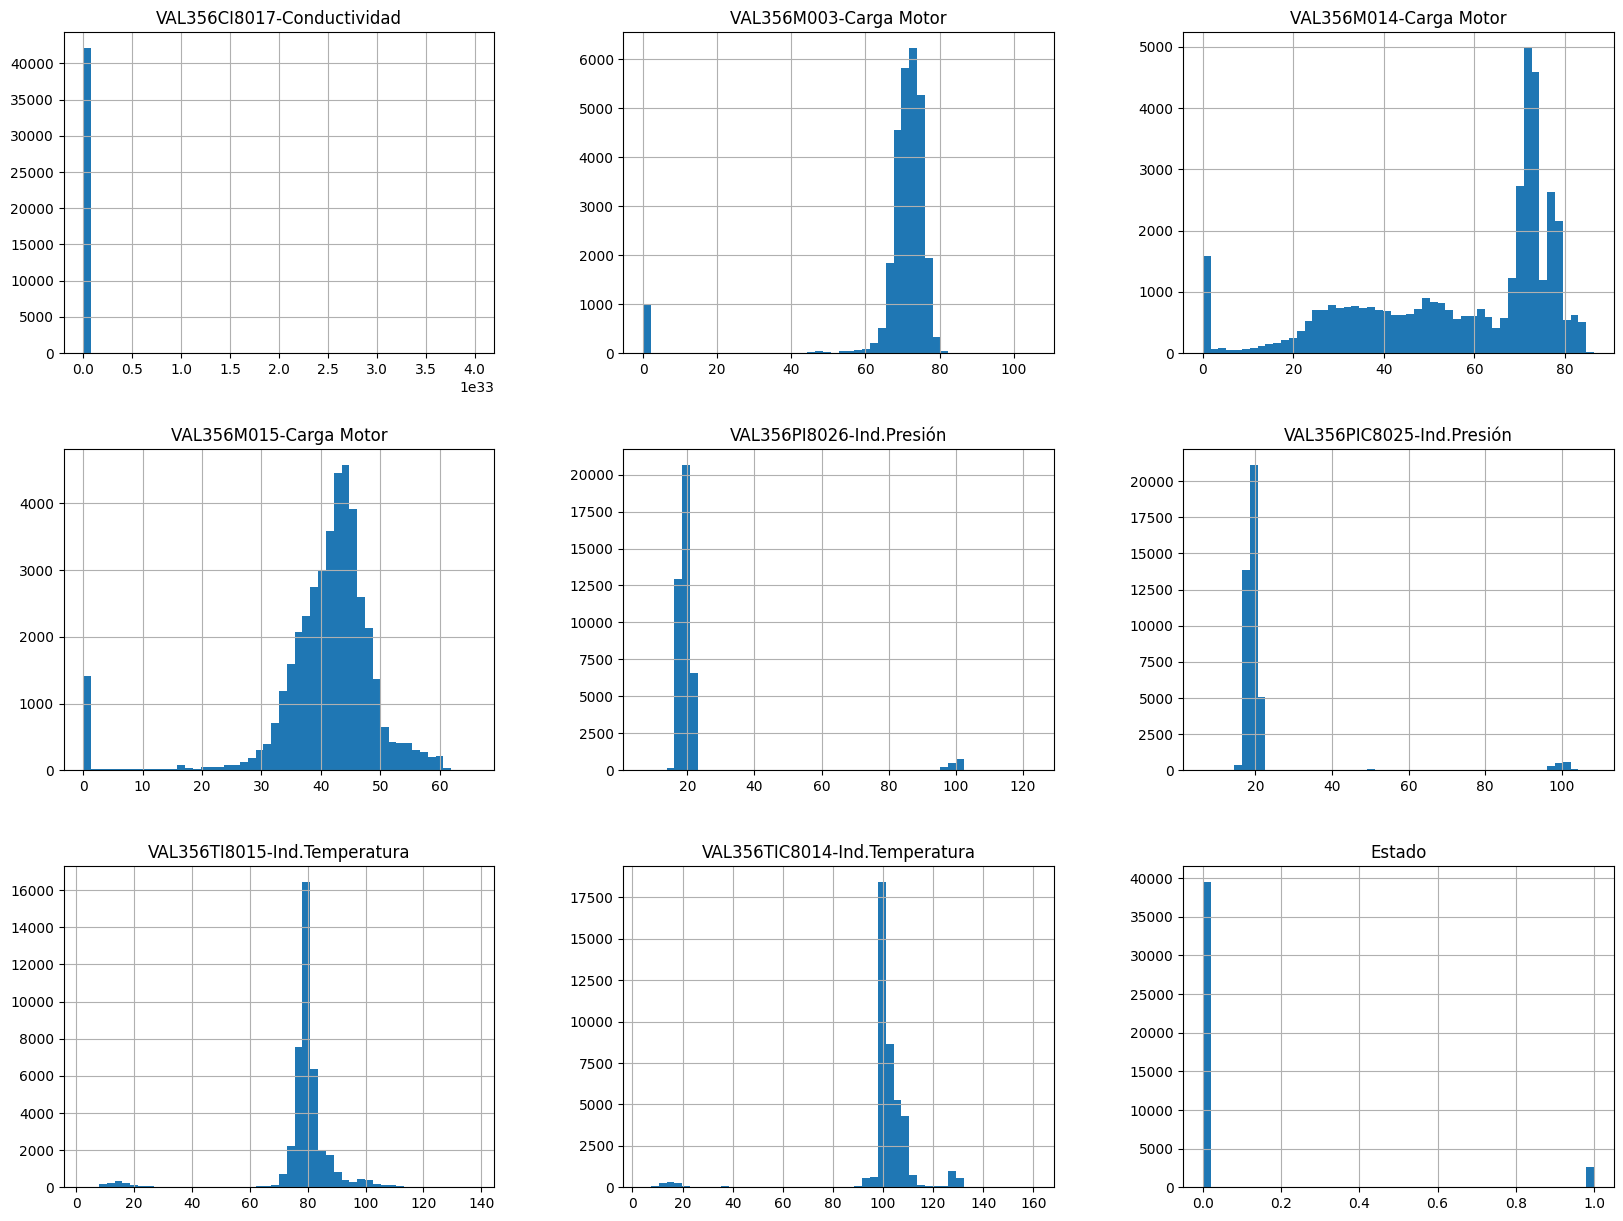

In [7]:
%matplotlib inline
r_pandas.hist(bins=50, figsize=(20,15))

In [8]:
r_pandas.shape

(42206, 10)

## Splitting and processing the data

#### Splitting -> train, val, and test set
#### Processing -> filling nan with mean and normalizing numeric values

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = r.split_and_process_data(r_pandas, save_pipeline=True)

In [10]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (27011, 8)
y_train (27011,)
X_val (6753, 8)
y_val (6753,)
X_test (8442, 8)
y_test (8442,)


## Creating the model

In [11]:
model = r.create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________


2023-02-15 15:37:05.017785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 15:37:05.074189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 15:37:05.074383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 15:37:05.075391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## Training the model

In [12]:
r.train_model(model, X_train, y_train, X_val, y_val, epochs=100, name=None)

Epoch 1/100


2023-02-15 15:37:06.807261: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f97b001e470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-15 15:37:06.807282: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-02-15 15:37:06.811517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-15 15:37:06.878851: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Arquivo ou diretório inexistente
2023-02-15 15:37:06.916753: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


845/845 [==============================] - 4s 3ms/step - loss: 0.2577 - accuracy: 0.9253 - val_loss: 0.2335 - val_accuracy: 0.9365
Epoch 2/100
845/845 [==============================] - 2s 2ms/step - loss: 0.2313 - accuracy: 0.9357 - val_loss: 0.2250 - val_accuracy: 0.9365
Epoch 3/100
845/845 [==============================] - 2s 2ms/step - loss: 0.2212 - accuracy: 0.9357 - val_loss: 0.2146 - val_accuracy: 0.9365
Epoch 4/100
845/845 [==============================] - 2s 2ms/step - loss: 0.2090 - accuracy: 0.9357 - val_loss: 0.2007 - val_accuracy: 0.9365
Epoch 5/100
845/845 [==============================] - 2s 2ms/step - loss: 0.1937 - accuracy: 0.9357 - val_loss: 0.1844 - val_accuracy: 0.9365
Epoch 6/100
845/845 [==============================] - 2s 2ms/step - loss: 0.1759 - accuracy: 0.9357 - val_loss: 0.1660 - val_accuracy: 0.9365
Epoch 7/100
845/845 [==============================] - 2s 2ms/step - loss: 0.1556 - accuracy: 0.9362 - val_loss: 0.1458 - val_accuracy: 0.9374
Epoch 8/100

## Visualizing training curves with Tensorboard

In [5]:
%reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

Reusing TensorBoard on port 6006 (pid 75596), started 0:00:02 ago. (Use '!kill 75596' to kill it.)

## Saving the model

In [14]:
r.save_model(model)

## Loading the model

In [15]:
loaded_model = r.load_model('model.h5')

## Evaluating test set with confusion matrix

264/264 [==============================] - 0s 1ms/step
Accuracy on test set: 0.996090973702914


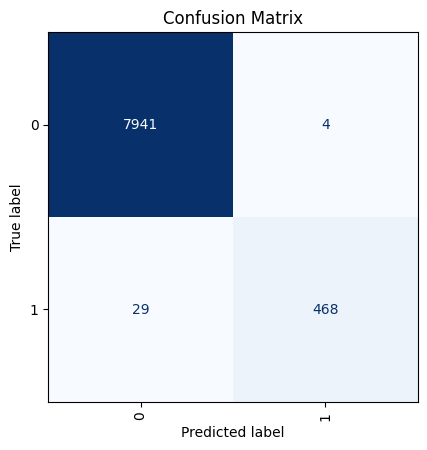

In [16]:
r.evaluate_model(loaded_model, X_test, y_test)

## ROC Curve

264/264 [==============================] - 0s 1ms/step
AUC = 0.9998153806413053


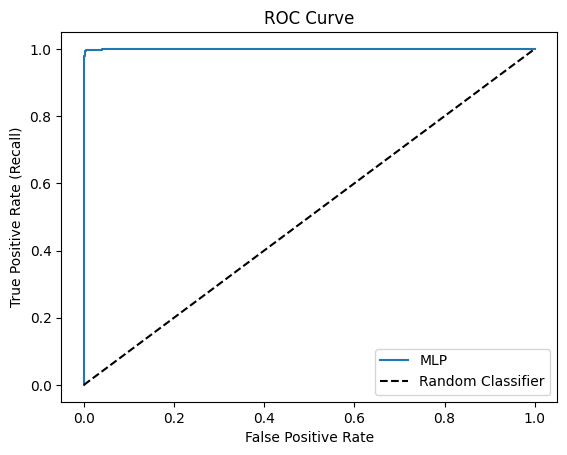

In [17]:
r.plot_roc_curve(loaded_model, X_test, y_test, label='MLP')

## Predictions on "new" data

In [18]:
new_data = ReboilerBinaryClassifier('Reboiler_Raw Data_With Timestamps.csv')
new_data_pandas = new_data.load_data()
points_num = 30
start_point = np.random.randint(0, new_data_pandas.shape[0]-points_num)
end_point = start_point + points_num
new_data_pandas_X = new_data_pandas.iloc[start_point:end_point, :-1]

In [19]:
new_data_pandas_X.head()

,Fecha,VAL356CI8017-Conductividad,VAL356M003-Carga Motor,VAL356M014-Carga Motor,VAL356M015-Carga Motor,VAL356PI8026-Ind.Presión,VAL356PIC8025-Ind.Presión,VAL356TI8015-Ind.Temperatura,VAL356TIC8014-Ind.Temperatura
34772,2016-12-15 11:38:00,4.0,NaN,73.645953,42.859406,16.435483,16.5,83.632689,100.782829
34773,2016-12-15 13:38:00,3.9,NaN,73.386617,43.855234,15.980147,16.5,89.305833,99.867936
34774,2016-12-15 15:38:00,4.0,NaN,72.843049,43.025774,16.380736,16.5,85.562144,100.055158
34775,2016-12-15 17:38:00,4.0,NaN,72.153357,43.507027,16.568438,16.5,79.852293,99.587852
34776,2016-12-15 19:38:00,4.0,NaN,72.566117,39.488216,16.641519,16.7,80.927069,99.983794


In [20]:
new_data.predict(model_path='model.h5', X_new=new_data_pandas_X, pipeline_path='pipeline.joblib')

1/1 [==============================] - 0s 35ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])